<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/05_transfer_learning_in_tensorflow_pt2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Pt2 Fine Tuning

In the previous notebook, we covered Feature Extraction. Now we'll cover another kind of Transfer Learning - Fine Tuning.

In [ ]:
!nvidia-smi

Tue Feb 21 23:24:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we created a bunch of helper functions. Rather than tediously rewriting them, we're going to learn how to import functions.

🔑 **Note**: If you're running this notebook in Google Colab, when it times out, Colab will delete the script and you'll have to redownload it (re-run !wget).

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-02-21 23:24:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-21 23:24:16 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Let's get data

This time we're going to see how we can use the pretrained models in tf.keras.applications and apply them to our own problem (recognizing images of food)
https://keras.io/api/applications/

In [ ]:
# Get 10% training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-21 23:24:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   228MB/s    in 0.7s    

2023-02-21 23:24:20 (228 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("/content/10_food_classes_10_percent.zip")

In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10

In [ ]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

`image_dataset_from_directory()`:

This is going to replace the `ImageDataGenerator` because it creates a `tf.data.Dataset` which is a handy tf datatype. You don't need to create a `datagen` and then apply it to the path_dir.

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

`BatchDataset` : means the function has changed data into batches. `None` leaves a dimension in the tensor for different batches.
The labels are one-hot encoded.

In [ ]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[236.33673    203.33673    160.33673   ]
   [218.24998    185.24998    144.24998   ]
   [208.32143    172.67857    135.10715   ]
   ...
   [224.34697    106.06139     96.704185  ]
   [235.4695     136.68387    111.85216   ]
   [248.15819    167.06659    131.40834   ]]

  [[235.4949     202.4949     159.4949    ]
   [217.69897    182.69897    142.69897   ]
   [209.91325    171.2857     136.04082   ]
   ...
   [203.81128     82.12259     74.10718   ]
   [206.9898      96.780685    76.20407   ]
   [221.76576    121.98523     91.1025    ]]

  [[237.21939    201.57652    162.21939   ]
   [216.92857    178.5        141.92857   ]
   [212.15817    169.06633    135.87756   ]
   ...
   [209.7348      83.75526     78.9184    ]
   [213.02046     91.07661     74.48983   ]
   [226.7298     106.44408     84.158295  ]]

  ...

  [[  5.857121     5.857121    65.857124  ]
   [  6.8010406    6.8010406   66.80104   ]
   [  5.2601995    5.0459137   65.04591   ]
   ...
   [254.16835    231.168

# Building a features extraction model with the Keras Functional API

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order. The Functional API gives more flexibility with our models.

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we want to add our own output layer

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input (shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2, you will need to normalize inputs.
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs into the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
print(f"Shape after output layer: {x.shape}")

# 8. Combine the inputs wiht the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent, 
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                   experiment_name="model_0")])




16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling2D: (None, 1280)
Shape after output layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20230221-232429
Epoch 1/5
24/24 [==============================] - 17s 119ms/step - loss: 1.9244 - accuracy: 0.3893 - val_loss: 1.3414 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - 1s 42ms/step - loss: 1.1115 - accuracy: 0.7720 - val_loss: 0.8718 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 1s 42ms/step - loss: 0.7978 - accuracy: 0.8093 - val_loss: 0.7087 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 1s 42ms/step - loss: 0.6380 - accuracy: 0.8680 - val_loss: 0.6121 - val_accuracy: 0.8668
Epoch 5/5
24/24 [==============================] - 1s 42ms/step - loss: 0.5470 - accuracy: 0.8880 - val_loss: 0.5575 - val_accuracy: 0.8701


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 2s 23ms/step - loss: 0.5567 - accuracy: 0.8656


[0.5566728115081787, 0.8655999898910522]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# how about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Summary of the entire model
model_0.summary()
# notice how efficientnetb0 is counted as a single layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


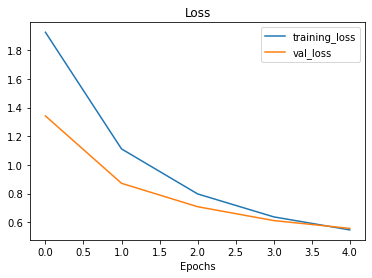

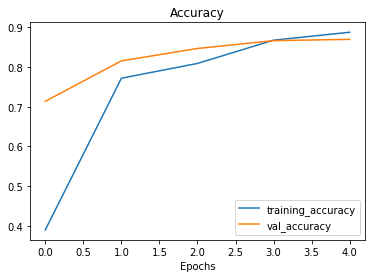

In [ ]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the `GlobalAveragePooling2D` layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280). But after passing through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and pass it through `GlobalAveragePooling2D`.


In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass random_tensor through GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # note the syntax!
print(f"2D Global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global average pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicated the Global Average Pooled 2D Layer
tf.reduce_mean(input_tensor, axis=[1,2])
# reduces the tensor to the mean of the values across the axes 1 and 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🛠 Try to do the same with the above 2 cells but this time use `GlobalMaxPool2D`

In [ ]:
input_shape = (1,4,4,3)
input_tensor = tf.random.normal(input_shape)
global_max_pool_2d_layer = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pooling_2d_layer = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"The input tensor is:\n {input_tensor} \n")
print(f"The global max pool 2D layer is:\n {global_max_pool_2d_layer} \n")
print(f"The global max pooling 2D layer is:\n {global_max_pooling_2d_layer} \n")
print(f"The shape of the input tensor is: {input_tensor.shape}")
print(f"The shape of the global_max_pool_2D_layer is {global_max_pool_2d_layer.shape}")
print(f"The shape of hte global max pooling 2D layer is {global_max_pooling_2d_layer.shape}")

The input tensor is:
 [[[[ 8.4224582e-02 -8.6090374e-01  3.7812304e-01]
   [-5.1962738e-03 -4.9453196e-01  6.1781919e-01]
   [-3.3082047e-01 -1.3840806e-03 -4.2373410e-01]
   [-1.3872087e+00 -1.5488191e+00 -5.3198391e-01]]

  [[-4.4756433e-01 -2.0115814e+00 -5.7926011e-01]
   [ 5.7938927e-01  1.3041967e+00  6.7720258e-01]
   [-7.4587613e-01  1.0378964e+00  1.3820479e+00]
   [ 1.4319172e+00 -3.7643117e-01  9.8158473e-01]]

  [[-2.3597860e-01 -3.3763257e-01 -8.9593250e-01]
   [ 4.2754072e-01 -3.8105518e-01  4.7006992e-01]
   [ 3.5413779e-02 -2.9272759e+00 -9.6707004e-01]
   [-4.1402709e-01 -4.0137586e-01  6.2328768e-01]]

  [[-9.3648863e-01  9.5449388e-01  4.9025390e-01]
   [-9.9804848e-01 -1.1686406e+00 -6.7897290e-01]
   [ 1.7331039e+00  7.8643024e-01  9.2237018e-02]
   [ 2.2711790e-01 -9.1896124e-02  1.1224977e+00]]]] 

The global max pool 2D layer is:
 [[1.7331039 1.3041967 1.3820479]] 

The global max pooling 2D layer is:
 [[1.7331039 1.3041967 1.3820479]] 

The shape of the input t

### What is a feature vector?

A learned represenation of the input data (a compressed form of the input data) based on how the model sees it. 

# Running a seris of transfer learning experiments

We've seen the incredible results transfer learning gets with 10% of the training data bue how does it go with 1% of the training data? We will set up a bunch of experiments to investigate this...

1. `model_1`: use feature extraction on 1% of the training data with data augmentation.
2. `model_2`: use feature extraction on 10% of the training data with data augmentation.
3. `model_3`: use fine tuning on 10% of the training data with data augmentation.
4. `model_4`: use fine tuning on 100% of the training data with data augmentation.

🔑 **Note**: the test_data is consistent through all experiments.


## `model_1`:Feature extraction on 1% of the data with augmentation.


### Getting the data

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("/content/10_food_classes_1_percent.zip")

--2023-02-21 23:24:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   116MB/s    in 1.1s    

2023-02-21 23:24:56 (116 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
walk_through_dir("/content/10_food_classes_1_percent/")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent/'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/t

In [ ]:
# Set up data loaders
train_dir = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test/"

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           image_size=(224,224),
                                                                           batch_size=32,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224,224),
                                                                batch_size=32,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into the model, we can use the layers:
* tf.keras.layers.experimental.preprocessing()

Benefits of doing data augmentation inside the model:
* Happens on the GPU (faster) rather than the CPU.
* It is only turned on during training, so this layer is "off" when the model is running a prediction i.e. the test data is not augmented. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet60 has Rescaling
], name="data_augmentation")

#### Visualize our data augmentation layer

(-0.5, 539.5, 407.5, -0.5)

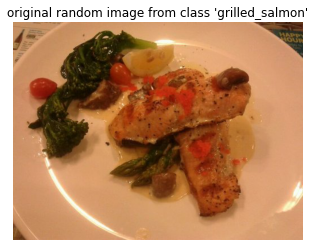

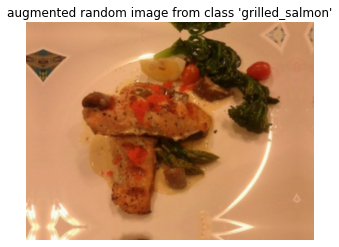

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "/content/10_food_classes_1_percent/train/" + target_class # remember this is a string
random_image=random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from class '{target_class}'")
plt.axis(False)

# Now let's plot our augmented random image
plt.figure()
augmented_img = data_augmentation(img)
plt.imshow(tf.cast(augmented_img, dtype=tf.int32)) 
# the code in parenthesis converts the float numbers to integers (0-255) for matplotlib. 
# alternative code converst it to floats between 0 and 1
# plt.imshow(augmented_img/255.)
plt.title(f"augmented random image from class '{target_class}'")
plt.axis(False)



### Creating the model

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
inputs = data_augmentation(inputs, training=False)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(inputs)
# # Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_1.summary()

# # Fit the model
history_1 = model_1.fit(train_data_1_percent, 
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                   experiment_name="model_1")]
)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Saving TensorBoard log files to: transfer_learning/model_1/20230221-232501
Epoch 1/5
3/3 [==============================] - 8s 1s/step - loss: 2.2708 - accuracy: 0.1857 - val_loss: 2.0652 - val_accuracy: 0.2911
Epoch 2/5
3/3 [==============================] - 1s 260ms/step - loss: 1.9934 - accuracy: 0.4143 - val_loss: 1.9215 - val_accuracy: 0.4112
Epoch 3/5
3/3 [==============================] - 1s 266ms/step - loss: 1.7578 - accuracy: 0.5714 - val_loss: 1.7931 - val_accuracy: 0.5230
Epoch 4/5
3/3 [==============================] - 1s 265ms/step - loss: 1.5527 - accuracy: 0.7429 - val_loss: 1.6746 - val_accuracy: 0.5806
Epoch 5/5
3/3 [==============================] - 1s 269ms/step - loss: 1.3864 - accuracy: 0.8571 - val_loss: 1.5917 - val_accuracy: 0.6151


### Evaluate the results of `model_1`

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug 

79/79 [==============================] - 2s 21ms/step - loss: 1.5778 - accuracy: 0.6272


[1.5777860879898071, 0.6272000074386597]

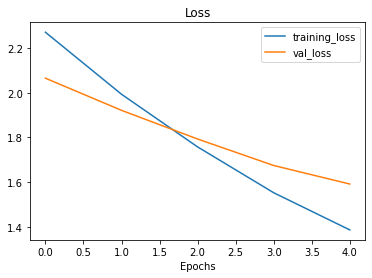

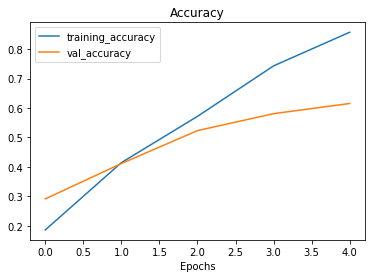

In [ ]:
# Evaluate loss curves
plot_loss_curves(history_1)

## `model_2`: feature extraction on 10% of the data with augmentation

### Getting the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-21 23:25:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2023-02-21 23:25:15 (164 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip.1")

In [ ]:
walk_through_dir("/content/10_food_classes_10_percent/")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent/'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1

In [ ]:
train_dir="/content/10_food_classes_10_percent/train/"
test_dir="/content/10_food_classes_10_percent/test/"

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size=(224,224),
                                                                             batch_size=32,
                                                                             label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224,224),
                                                                batch_size=32,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2)
    
], name="data_augmentation")

### Creating the model

In [ ]:
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
input = keras.layers.Input (shape=(224,224,3), name="input_layer")
x = data_augmentation(input)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(input,output)
model_2.summary()

model_2.compile (loss = "categorical_crossentropy", 
                 optimizer="Adam", 
                 metrics="accuracy")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a `ModelCheckpointCallback`
This callback immediately saves our full model (or just the weights) so we can pick up where we left off.

In [ ]:
# Set checkpoint path
import datetime
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
# Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                      save_weights_only=True, 
                                                      save_best_only=False,
                                                      save_freq="epoch", # save every epoch
                                                      verbose=1)

In [ ]:
initial_epochs=5
history_2 = model_2.fit(train_data_10_percent,
            epochs=initial_epochs,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="/content/transfer_learning", experiment_name="model_2"),
                       checkpoint_callback])

Saving TensorBoard log files to: /content/transfer_learning/model_2/20230222-031135
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9751 - accuracy: 0.3653
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 250ms/step - loss: 1.9751 - accuracy: 0.3653 - val_loss: 1.4453 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2884 - accuracy: 0.6947
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 175ms/step - loss: 1.2884 - accuracy: 0.6947 - val_loss: 1.0074 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9993 - accuracy: 0.7653
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 181ms/step - loss: 0.9993 - accuracy: 0.7653 - val_loss: 0.8111 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.7787
Epoch 4

In [ ]:
# What were model_0 results?
results_0 = model_0.evaluate(test_data)
# Check model_2 results on all test_data
results_2 = model_2.evaluate(test_data)

results_0, results_2

79/79 [==============================] - 2s 21ms/step - loss: 0.6432 - accuracy: 0.8344


([0.5566731691360474, 0.8655999898910522],
 [0.6432152390480042, 0.8343999981880188])

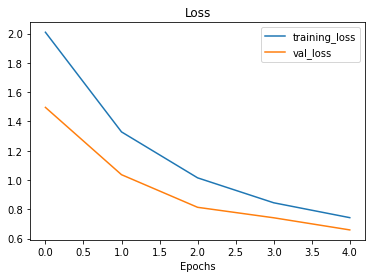

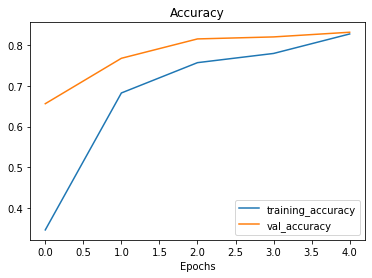

In [ ]:
plot_loss_curves(history_2)

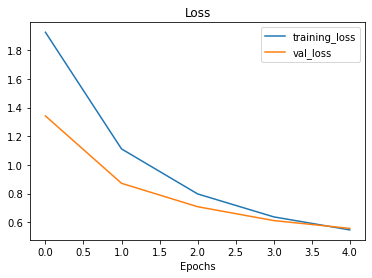

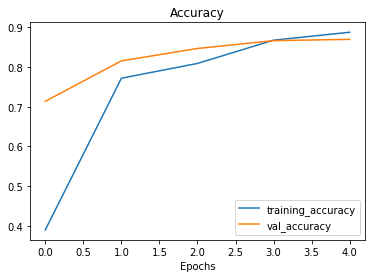

In [ ]:
plot_loss_curves(history_0)

### Loading in checkpoints and weights
Loading in checkpoints and weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [ ]:
loaded = model_2.evaluate(test_data)

79/79 [==============================] - 2s 21ms/step - loss: 0.6344 - accuracy: 0.8424


In [ ]:
results_2

[0.6343873739242554, 0.8424000144004822]

In [ ]:
model_2.evaluate(test_data) == results_2

79/79 [==============================] - 2s 21ms/step - loss: 0.6344 - accuracy: 0.8424


False

In [ ]:
# check to see if the loaded model resuklts are very close to our previous non-loaded results
import numpy as np 
np.isclose(np.array(loaded), np.array(results_2))

array([ True,  True])

In [ ]:
# check the difference 
print(np.array(loaded)-np.array(results_2))

[-1.78813934e-07  0.00000000e+00]


## `model_3`: fine tuning the model for 10% of the data augmented

🔑 **Note**: Fine tuning usually works best after training the feature extractor model for a few epochs with large amounts of custom data. Only then do you unfreeze some of the near-top layers.

### Investigating the trainable layers in `model_2`

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa2b82421c0> True
<keras.engine.sequential.Sequential object at 0x7fa2b8252640> True
<keras.engine.functional.Functional object at 0x7fa2b0672820> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa3286aa460> True
<keras.layers.core.dense.Dense object at 0x7fa2b0068790> True


In [ ]:
base_model

* Reminder: During the creation of, we set `base_model.trainable` to False.

In [ ]:
model_2.layers[1].layers

In [ ]:
# layers[2] is the base_model which has its own layers
# what layers are in our base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers): 
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# how many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
base_model.trainable=False

In [ ]:
### Making layers in the `base_layer` (EfficientNet60) trainable.print(len(model_2.layers[2].trainable_variables))

### Making layers in the `base_layer` (EfficientNet60) trainable.

🔑 NOTE: It's important that you do it this way, by setting the `base_model.trainable` to `True` before setting the individual layers to `False` and `True`.

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])
# when fine-tuning, you typically want to lower the learning_rate by 10x


In [ ]:
len(base_model.layers)

238

In [ ]:
for i, layer in enumerate(base_model.layers): 
  print(i, layer.name, layer.trainable)

0 input_7 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [ ]:
print(base_model.layers)

[<keras.engine.input_layer.InputLayer object at 0x7fa2b841d400>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa2b824e8e0>, <keras.layers.preprocessing.normalization.Normalization object at 0x7fa2b8242fd0>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa2b8304a00>, <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fa328327f40>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7fa38fb45b20>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa3282c5d30>, <keras.layers.core.activation.Activation object at 0x7fa3282c5af0>, <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fa38c43b430>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa2b8372f10>, <keras.layers.core.activation.Activation object at 0x7fa3284b22b0>, <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa3286a8b80>, <keras.layers.reshaping.

**Note**: When using fine-tuning, it is better to lower the learning rate. A good rule of thumb is by at least 10x. 
* 📖 UMLFit Paper https://arxiv.org/abs/1801.06146

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print (i, layer.name, layer.trainable)

0 input_7 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
for layer in model_2.layers:
  print (layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa2b82421c0> True
<keras.engine.sequential.Sequential object at 0x7fa2b8252640> True
<keras.engine.functional.Functional object at 0x7fa2b0672820> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa3286aa460> True
<keras.layers.core.dense.Dense object at 0x7fa2b0068790> True


In [ ]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [ ]:
# fine tune another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model 

history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        initial_epoch=history_2.epoch[-1], # start training from previous last epoch
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="model_3"), 
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/model_3/20230222-031316
Epoch 5/10


24/24 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.8333
Epoch 5: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 250ms/step - loss: 0.6282 - accuracy: 0.8333 - val_loss: 0.5047 - val_accuracy: 0.8297
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.8480
Epoch 6: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 5s 188ms/step - loss: 0.5037 - accuracy: 0.8480 - val_loss: 0.4971 - val_accuracy: 0.8281
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8787
Epoch 7: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 5s 195ms/step - loss: 0.4227 - accuracy: 0.8787 - val_loss: 0.4817 - val_accuracy: 0.8328
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8800
Epoc

### Evaluate the results of `model_3`

In [ ]:
# Evaluate the fine-tuned model_3 (which is actually model_2 fine-tuned for another 5 epochs)
results_3 = model_2.evaluate(test_data)

79/79 [==============================] - 2s 21ms/step - loss: 0.4513 - accuracy: 0.8472


In [ ]:
results_2

[0.6432152390480042, 0.8343999981880188]

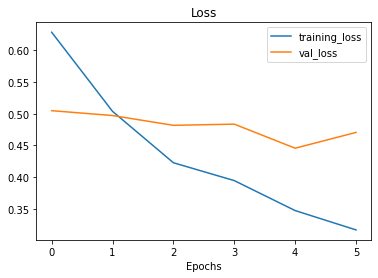

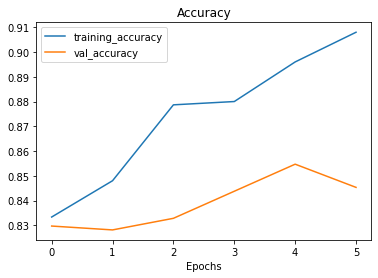

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_3)

The `plot_loss_curves` function works great with models which have onlybeen fit once. However we want something to compare one series of running `fit()` with another (i.e. before and after fine-tuning). A function to compare training histories.

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares 2 Tensorflow history objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = acc + new_history.history["val_accuracy"]
  total_val_loss = loss + new_history.history["val_loss"]

  # make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="start fine tuning")
  plt.legend(loc="lower right")
  plt.title("Traning and Validation Accuracy")

  # make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="start fine tuning")
  plt.legend(loc="upper right")
  plt.title("Traning and Validation Loss")


In [ ]:
compare_historys (history_2, history_3, initial_epochs=5) # it's zero-indexed that's why it's epoch=4 in the plot

## `model_4`: fine tuning the model with 100% of the training data

### Get the full dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
walk_through_dir("10_food_classes_all_data")

In [ ]:
train_dir="/content/10_food_classes_all_data/train/"
test_dir="/content/10_food_classes_all_data/test/"

In [ ]:
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                      image_size=(224,224),
                                                                      batch_size=32,
                                                                      label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=32,
                                                                image_size=(224,224),
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset has been common across all the experiments.

In [ ]:
# Evaluate model_2 (fine tuned on 10% of training data)
model_2.evaluate(test_data), results_2

To train a fine-tuning model (`model_4`), we need to revert `model_3` (although it's called `model_2`) back to its feature-extractor weights after fitting as `model_2`. That way we can fine-tune from the same stage that the 10percent data model was fine-tuned from.

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 2s 22ms/step - loss: 0.4513 - accuracy: 0.8472


[0.4512880742549896, 0.8471999764442444]

In [ ]:
results_2

[0.6432152390480042, 0.8343999981880188]

In [ ]:
results_3

[0.4512886703014374, 0.8471999764442444]

In [ ]:
# model_4.fit(train_data_full, epochs=5, steps_per_epoch=len(train_data_full),
#             validation_data=text_data, validation_steps=len(text_data),
#             callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="model_4")])

1. Trained a feature extractor transfer learning model for 5 epochs on 10% of the data with data augmentation (`model_2`) and we saved the model's weights using `ModelCheckpoint`.

2. We fine-tuned the same model on the same 10% of the data with the top 10 layers of the base model unfrozen (`model_3`).

3. We saved the results and training logs (history) each time.

4. We reloaded the model from step 1 ot do the same steps as step 2 except this time, we're going to use all of the data. (`model_4`).

In [ ]:
# Check which layers are trainable

for i, layer in enumerate(model_2.layers):
  print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fa2957e68e0> True
1 <keras.engine.sequential.Sequential object at 0x7fa2b8357fa0> True
2 <keras.engine.functional.Functional object at 0x7fa29c7e4bb0> True
3 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa29c7b49d0> True
4 <keras.layers.core.dense.Dense object at 0x7fa2b8477760> True


In [ ]:
# let's drill into our base model
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_7 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

### Compile the model

In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics="accuracy")

In [ ]:
fine_tune_epochs = initial_epochs + 5


history_4 = model_2.fit(train_data_full, 
                        epochs=fine_tune_epochs,
                        initial_epoch = history_2.epoch[-1],
                        validation_data = test_data,
                        validation_steps=0.25*len(test_data),
                        callbacks = [create_tensorboard_callback(dir_name="/content/transfer_learning", experiment_name="model_4")])





Saving TensorBoard log files to: /content/transfer_learning/model_4/20230222-032652
Epoch 5/10


235/235 [==============================] - 46s 152ms/step - loss: 0.5238 - accuracy: 0.8321 - val_loss: 0.3003 - val_accuracy: 0.8969
Epoch 6/10
235/235 [==============================] - 34s 143ms/step - loss: 0.4673 - accuracy: 0.8465 - val_loss: 0.2980 - val_accuracy: 0.9062
Epoch 7/10
235/235 [==============================] - 34s 145ms/step - loss: 0.4243 - accuracy: 0.8617 - val_loss: 0.3311 - val_accuracy: 0.8828
Epoch 8/10
235/235 [==============================] - 35s 148ms/step - loss: 0.3940 - accuracy: 0.8751 - val_loss: 0.2652 - val_accuracy: 0.9156
Epoch 9/10
235/235 [==============================] - 35s 147ms/step - loss: 0.3567 - accuracy: 0.8829 - val_loss: 0.2851 - val_accuracy: 0.9016
Epoch 10/10
235/235 [==============================] - 33s 140ms/step - loss: 0.3337 - accuracy: 0.8909 - val_loss: 0.2963 - val_accuracy: 0.9078


### Evaluate the results of `model_4`

In [ ]:
results_4 = model_2.evaluate(test_data)

79/79 [==============================] - 2s 21ms/step - loss: 0.3029 - accuracy: 0.9052


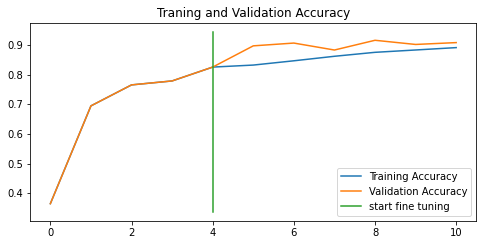

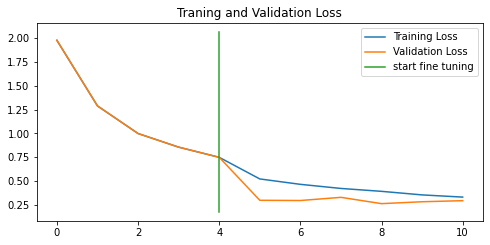

In [ ]:
compare_historys(original_history=history_2, new_history=history_4)

# Viewing our experiment data on TensorBoard

In [ ]:
# View tensorboard logs of transfer learning modelling experiments 
# Upload Tensorboard Dev logs
!tensorboard dev upload --logdir ./transfer_learning/ \
--name "Transfer Learning Experiments with 10 Food101 Classes" \
--description "A series of different TL experiments with varying amounts of data and fine tuning" \
--one_shot #exits the uploader once it finishes uploading

2023-02-22 03:35:47.765203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 03:35:47.765305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 03:35:47.765329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning/

This TensorB

In [ ]:
!tensorboard list

2023-02-22 03:44:00.436030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 03:44:00.436116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 03:44:00.436133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
usage: tensorboard
       [-h]
       [--helpfull]
       {serve,dev}
       ...
tensorboard: error: invalid choice: 'list' (choose from 'serve', 'dev')
